In [272]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json


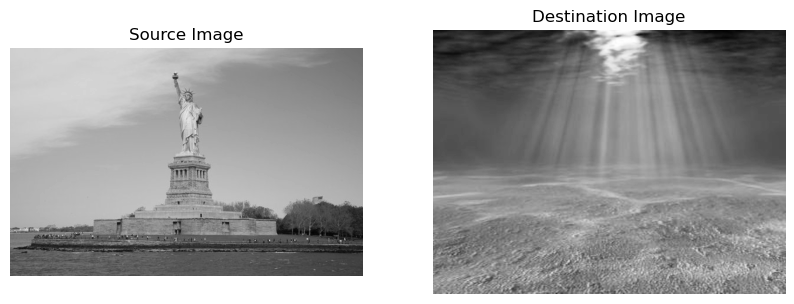

In [286]:
# Setting the paths for the source and target image
img_folder_path = os.path.join(os.getcwd(),"Images")
src_img_path = os.path.join(img_folder_path, "source.jpg")
target_img_path = os.path.join(img_folder_path, "target.jpg")

# Storing the images as numpy arrays
src_img = cv2.imread(src_img_path, cv2.IMREAD_GRAYSCALE)
target_img = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the source image
axes[0].imshow(src_img, cmap='grey')
axes[0].set_title('Source Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Plot the destination image
axes[1].imshow(target_img, cmap='grey')
axes[1].set_title('Destination Image')
axes[1].axis('off')

plt.show()

Mask saved as 'polygon_mask.jpg'


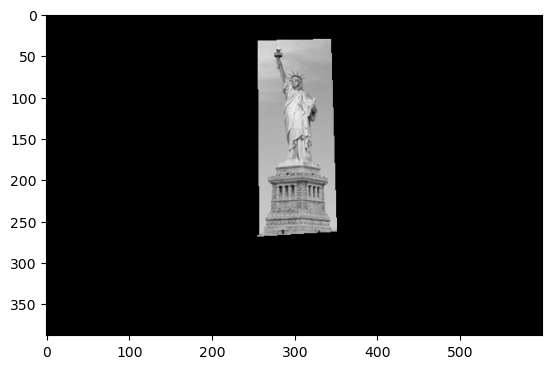

In [287]:
!python select_region.py "{src_img_path}"

# Read the saved region coordinates
with open('selected_polygon.json', 'r') as file:
    polygon_points = json.load(file)

polygon_points = np.array(polygon_points, dtype=np.int32)

# Create a mask with the same dimensions as the source image
mask = np.zeros_like(src_img)
cv2.fillPoly(mask, [polygon_points], 255)

# Extract the region of interest
selected_region = cv2.bitwise_and(src_img, mask)

mask_img_path = os.path.join(img_folder_path, 'source_mask.jpg')
mask_path = os.path.join(img_folder_path, 'mask.jpg')
cv2.imwrite(mask_img_path, selected_region)
cv2.imwrite(mask_path,mask)
print("Mask saved as 'polygon_mask.jpg'")

# Display the extracted region
plt.imshow(selected_region, cmap='gray')
plt.show()

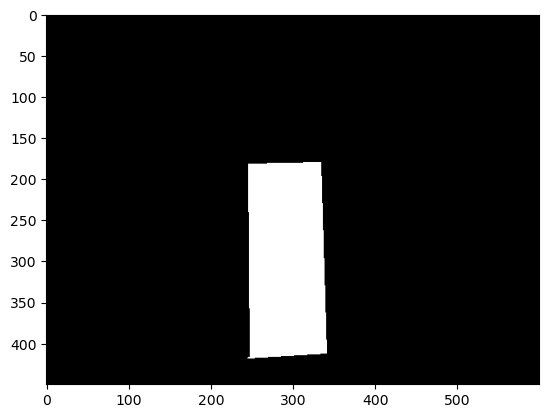

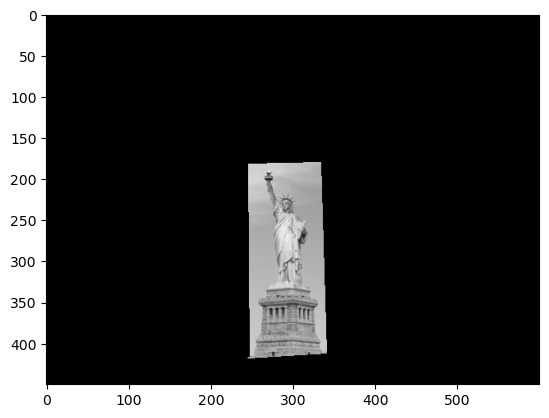

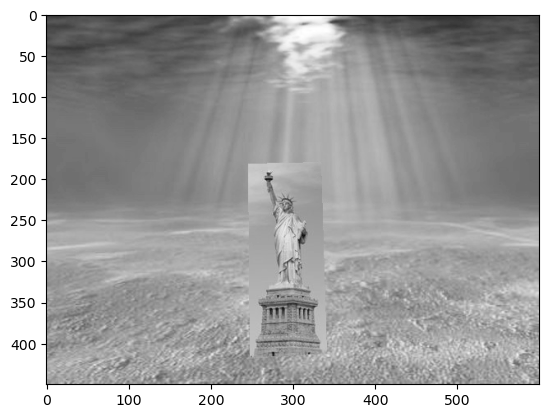

In [296]:
import mask_mover

result_path = os.path.join(img_folder_path,"target_without_region.jpg")

offset = mask_mover.move_mask(target_img_path, "selected_polygon.json", result_path)
target_without_region = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
def translate_mask(mask, offset):
    """
    Translate a binary mask by a given offset.
    """
    # Create the translation matrix
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    
    # Translate the mask
    translated_mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    return translated_mask

def pad_array_to_match(target_array, array_to_pad):

    # Calculate the padding required for each dimension
    padding = [(0, max(0, t - s)) for s, t in zip(array_to_pad.shape, target_array.shape)]

    # Pad the array
    padded_array = np.pad(array_to_pad, pad_width=padding, mode='constant', constant_values=0)

    return padded_array

src_mask = pad_array_to_match(target_img, selected_region)
src_mask = translate_mask(src_mask, offset)
new_mask = pad_array_to_match(target_img, mask)
new_mask = translate_mask(new_mask, offset)
plt.imshow(new_mask, cmap="grey")
plt.show()
plt.imshow(src_mask, cmap="grey")
plt.show()
final_image = target_without_region + src_mask
plt.imshow(final_image, cmap='gray')
plt.show()


In [297]:
import scipy.sparse
def laplacian_matrix(n, m):   
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)
    
    return mat_A

laplacian_matrix(3, 3).todense()

matrix([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
        [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
        [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

In [298]:
if np.isin(new_mask, [0, 1]).all():
    pass
else:
    # Convert to binary by setting values greater than 0 to 1
    new_mask = np.where(new_mask > 0, 1, 0)

In [299]:
y_max, x_max = target_img.shape
y_min, x_min = 0, 0
y_range = y_max - y_min
x_range = x_max - x_min
mat_A = laplacian_matrix(y_range, x_range)
laplacian = mat_A.tocsc()

In [300]:
offset = (0, 100)
M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
src_img = cv2.warpAffine(src_img, M, (x_range, y_range))

In [301]:
for y in range(1, y_range - 1):
    for x in range(1, x_range - 1):
        if new_mask[y, x] == 0:
            k = x + y * x_range
            mat_A[k, k] = 1
            mat_A[k, k + 1] = 0
            mat_A[k, k - 1] = 0
            mat_A[k, k + x_range] = 0
            mat_A[k, k - x_range] = 0
mat_A = mat_A.tocsc()

In [302]:
from scipy.sparse.linalg import spsolve

mask_flat = new_mask.flatten()    
source_flat = src_img[y_min:y_max, x_min:x_max].flatten()
target_flat = target_img[y_min:y_max, x_min:x_max].flatten()        

# inside the mask:
# \Delta f = div v = \Delta g       
alpha = 1.0
mat_b = laplacian.dot(source_flat) * alpha

# outside the mask:
# f = t
mat_b[mask_flat == 0] = target_flat[mask_flat == 0]

x = spsolve(mat_A, mat_b)    
x = x.reshape((y_range, x_range))
x[x > 255] = 255
x[x < 0] = 0
x = x.astype('uint8')

target_img[y_min:y_max, x_min:x_max] = x

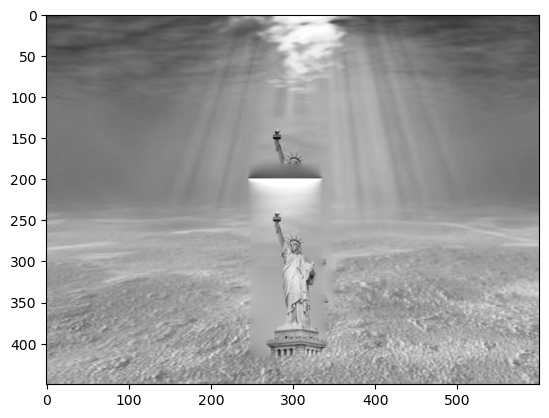

In [303]:
plt.imshow(target_img, cmap='grey')
plt.show()